## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,roc_auc_score, log_loss
# classifiers
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier


## Data Path and other config

In [2]:
# change if you dont have the data in this path like our repo
DATA_PATH = "data/Drug.csv"  
OUT_DIR = "drug_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# random seed and cross validation settings
RANDOM_STATE = 42
N_SPLITS = 5
TEST_SIZE = 0.2

## Loading Data

In [3]:
df = pd.read_csv(DATA_PATH)
target_column = "Drug"  
feature_columns = [col for col in df.columns if col != target_column]
 # shape check
print(f"Data shape: {df.shape}")
df.head()

Data shape: (200, 7)


,Age,Sex,BP,Cholesterol,Na,K,Drug
0,23,F,HIGH,HIGH,0.792535,0.031258,drugY
1,47,M,LOW,HIGH,0.739309,0.056468,drugC
2,47,M,LOW,HIGH,0.697269,0.068944,drugC
3,28,F,NORMAL,HIGH,0.563682,0.072289,drugX
4,61,F,LOW,HIGH,0.559294,0.030998,drugY


## Data info

In [4]:
print("="*50)
print(f"Dtypes:")
print("="*50)
print(df.dtypes)
print("="*50)
print(f"Missing values per column:")
print("="*50)
print(f"{df.isna().sum()}")
print("="*50)
print(f"Duplicate rows: {int(df.duplicated().sum())}")
print("="*50)

Dtypes:
Age              int64
Sex             object
BP              object
Cholesterol     object
Na             float64
K              float64
Drug            object
dtype: object
Missing values per column:
Age            0
Sex            0
BP             0
Cholesterol    0
Na             0
K              0
Drug           0
dtype: int64
Duplicate rows: 0


## Feature Types

In [5]:
categorical_features, numeric_features = [], []
for c in feature_columns:
    if df[c].dtype == "object":
        categorical_features.append(c)
    else:
        nunique = df[c].nunique()

        # here i am treating low-cardinality integers as categorical
        if nunique <= 10 and df[c].dtype.kind in "iu":
            categorical_features.append(c)
        else:
            numeric_features.append(c)

for c in categorical_features:
    df[c] = df[c].astype("category")


display(df[numeric_features].describe().T if numeric_features else pd.DataFrame())
display(df[categorical_features].describe().T if categorical_features else pd.DataFrame())


,count,mean,std,min,25%,50%,75%,max
Age,200.0,44.315000,16.544315,15.000000,31.000000,45.000000,58.000000,74.000000
Na,200.0,0.697095,0.118907,0.500169,0.583887,0.721853,0.801494,0.896056
K,200.0,0.050174,0.017611,0.020022,0.035054,0.049663,0.066000,0.079788


,count,unique,top,freq
Sex,200,2,M,104
BP,200,3,HIGH,77
Cholesterol,200,2,HIGH,103


## Correlation Matrix

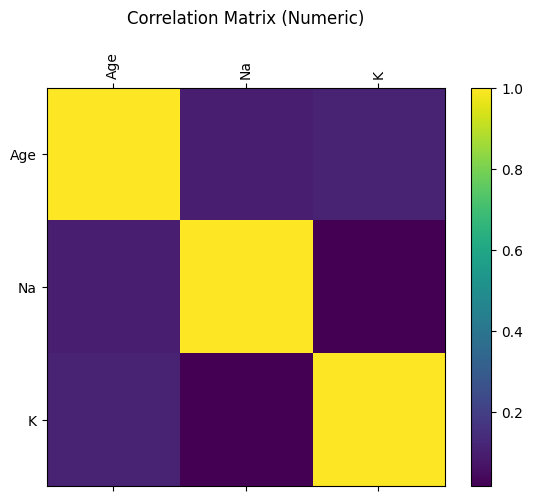

In [6]:
if len(numeric_features) >= 2:
    corr = df[numeric_features].corr(numeric_only=True)
    plt.figure(figsize=(6,5))
    ax = plt.gca()
    cax = ax.matshow(corr.values)
    plt.xticks(range(len(numeric_features)), numeric_features, rotation=90)
    plt.yticks(range(len(numeric_features)), numeric_features)
    plt.title("Correlation Matrix (Numeric)", pad=20)
    plt.colorbar(cax)
    plt.tight_layout()
    plt.show()

## Splitting

In [7]:
X = df[feature_columns].copy()
y = df[target_column].astype("category").cat.codes
label_to_class = dict(enumerate(df[target_column].astype("category").cat.categories))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=RANDOM_STATE
)
print(f"Train shape: {X_train.shape} Test shape: {X_test.shape}")
print(f"Classes: {label_to_class}")



Train shape: (160, 6) Test shape: (40, 6)
Classes: {0: 'drugA', 1: 'drugB', 2: 'drugC', 3: 'drugX', 4: 'drugY'}


## Pipeline for Preprocessing

In [8]:

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## Models to train

In [9]:
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "RidgeCls": RidgeClassifier(),
    "LinearSVC": LinearSVC(),
    "SVC_RBF": SVC(probability=True, kernel="rbf"),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
    "ExtraTrees": ExtraTreesClassifier(random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "SGDLog": SGDClassifier(loss='log_loss', max_iter=1000, random_state=RANDOM_STATE)
}

## Helper function
Soome models (MultinomialNB and GaussianNB) expect data to be processed differently. 

In [10]:
def build_pipeline_for(model_name, estimator):
    if model_name == "MultinomialNB":
        special_pre = ColumnTransformer(
            transformers=[
                ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), numeric_features),
                ("cat", categorical_transformer, categorical_features)
            ],
            remainder="drop"
        )
        return Pipeline([("pre", special_pre), ("clf", estimator)])
    if model_name == "GaussianNB":
        dense_pre = ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, numeric_features),
                ("cat", categorical_transformer, categorical_features)
            ],
            remainder="drop"
        )
        return Pipeline([
            ("pre", dense_pre),
            ("to_dense", FunctionTransformer(lambda x: x.toarray() if hasattr(x, "toarray") else np.asarray(x))),
            ("clf", estimator)
        ])
    return Pipeline([("pre", preprocessor), ("clf", estimator)])

## Cross Val and training

In [11]:
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
scoring = {"accuracy": "accuracy", "f1_macro": "f1_macro", "f1_weighted": "f1_weighted"}

rows = []
for name, est in models.items():
    pipe = build_pipeline_for(name, est)
    cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
    rows.append({
        "model": name,
        "cv_accuracy_mean": float(np.mean(cv_res["test_accuracy"])),
        "cv_f1_macro_mean": float(np.mean(cv_res["test_f1_macro"])),
        "cv_f1_weighted_mean": float(np.mean(cv_res["test_f1_weighted"]))
    })

leaderboard = pd.DataFrame(rows).sort_values(by=["cv_f1_macro_mean", "cv_accuracy_mean"], ascending=False)
leaderboard_path = os.path.join(OUT_DIR, "leaderboard_cv.csv")
leaderboard.to_csv(leaderboard_path, index=False)
leaderboard


,model,cv_accuracy_mean,cv_f1_macro_mean,cv_f1_weighted_mean
2,LinearSVC,0.95625,0.948382,0.955793
6,RandomForest,0.93750,0.939077,0.936322
0,LogReg,0.95000,0.937895,0.947083
11,SGDLog,0.93750,0.920240,0.934689
8,GradientBoosting,0.91250,0.908713,0.910039
5,DecisionTree,0.89375,0.895814,0.893816
3,SVC_RBF,0.90000,0.871919,0.894387
7,ExtraTrees,0.89375,0.869975,0.887591
1,RidgeCls,0.88125,0.817189,0.866260
4,KNN,0.83125,0.790779,0.827902


## Model Evaluation

In [12]:

final_rows, conf_mats = [], {}
for name in leaderboard["model"].tolist():
    pipe = build_pipeline_for(name, models[name]).fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    metrics = {
        "model": name,
        "test_accuracy": accuracy_score(y_test, y_pred),
        "test_f1_macro": f1_score(y_test, y_pred, average="macro"),
        "test_f1_weighted": f1_score(y_test, y_pred, average="weighted")
    }

    # probability-based metrics (Not all have this)
    try:
        if hasattr(pipe, "predict_proba"):
            proba = pipe.predict_proba(X_test)
            metrics["test_roc_auc_ovr"] = roc_auc_score(y_test, proba, multi_class="ovr")
            metrics["test_log_loss"] = log_loss(y_test, proba)
    except Exception:
        pass

    final_rows.append(metrics)
    conf_mats[name] = confusion_matrix(y_test, y_pred)

final_df = pd.DataFrame(final_rows).sort_values(by=["test_f1_macro", "test_accuracy"], ascending=False)
final_df_path = os.path.join(OUT_DIR, "final_test_results.csv")
final_df.to_csv(final_df_path, index=False)
final_df


,model,test_accuracy,test_f1_macro,test_f1_weighted,test_roc_auc_ovr,test_log_loss
0,LinearSVC,0.950,0.969474,0.948816,NaN,NaN
2,LogReg,0.950,0.969474,0.948816,0.999495,0.284862
3,SGDLog,0.925,0.953036,0.921964,0.991553,1.014412
6,SVC_RBF,0.900,0.897778,0.898611,0.995067,0.306037
9,KNN,0.875,0.886220,0.873540,0.966412,1.267842
1,RandomForest,0.850,0.824031,0.846701,0.973587,0.437058
8,RidgeCls,0.825,0.769206,0.814325,NaN,NaN
7,ExtraTrees,0.850,0.765455,0.840909,0.982297,0.400685
4,GradientBoosting,0.825,0.730116,0.821927,0.968437,1.299941
5,DecisionTree,0.800,0.709657,0.800137,0.827572,7.208731
